In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from functools import reduce
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('df.csv')

In [4]:
df.head()

,Unnamed: 0,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8
0,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Basic preprocessing: filling NaN values with 0, deleting spare column and changing float type to integer

In [5]:
df = df.fillna(0)
df = df.drop('Unnamed: 0', axis=1)
for i in df[df.select_dtypes('float64').columns]:
            df[i] = df[i].astype('int64')

### Visualization of different Actions occurences in the dataset

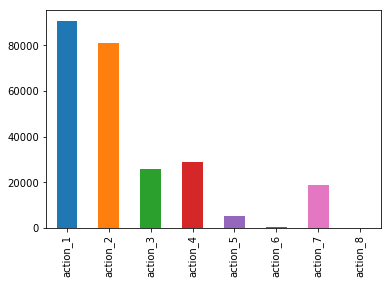

In [6]:
# calculate occurrence(support) for every action in all transactions
product_support_dict = {}
for column in df.columns:
    product_support_dict[column] = sum(df[column]>0)

# visualise support
pd.Series(product_support_dict).plot(kind="bar")

### Clustering (grouping) with Market Basket Analysis filtering


#### Explanation of the approach taken

Let's imagine that every 'Action' is an action of booking/buying a certain item.

I assume (from the example given and from the type of data given) that the 'similarity measure' used consisted in counting number of times certain unique action (item) combinations took place. 

However there is no reason to keep those unique groups/clusters of items which co-occurences seems random. That's why I will delete those with less than 10 co-occurences (though that's a bit arbitraty) and then I will apply Market Basket Analysis after grouping in order to leave only those groups/ clusters, which seems to surpass some confidence and lift levels, which we will state below.

After filtering I will simply select top-5 groups with the most frequent co-occurence.

So, I proceed with following steps:
1. Grouping unique co-occurences;
2. Market Basket Analysis; 
3. Filtering out random clusters and leaving top-5 with the most frequent co-occurence.

At the end of the day, raw application of other clustering techniques, such as hierarchical clustering, k-means etc. are not so interpretable here as simple Market Basket analysis.

#### Grouping

In [7]:
#Grouping data by unique action co-occurences
series = df.groupby(['action_1','action_2','action_3','action_4','action_5','action_6','action_7','action_8']).size()

In [8]:
new_df = series.to_frame(name = 'size').reset_index()

In [10]:
new_df.head()

,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,size
0,1,0,0,0,0,0,0,0,9267
1,1,0,0,0,1,1,0,0,1
2,1,0,0,1,0,0,0,0,72
3,1,0,0,1,0,0,1,0,30
4,1,0,1,0,0,0,0,0,499


In [11]:
#let's check starting number of gruops(clusters)
len(new_df)

41

In [12]:
copy = new_df.copy()

In [13]:
#let's iterate and fill in every '1' in every cluster with respective number of cluster size
cols = copy.columns
for index, row in copy.iterrows():
    count=0
    for value in row:
        if value==1:
            copy.set_value(index,cols[count],row['size'])
            count+=1
        else:
            count+=1
            

In [209]:
copy.head()

,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,size
0,9267,0,0,0,0,0,0,0,9267
1,1,0,0,0,1,1,0,0,1
2,72,0,0,72,0,0,0,0,72
3,30,0,0,30,0,0,30,0,30
4,499,0,499,0,0,0,0,0,499


In [14]:
#I will delete some clusters immediately - obvious cases where size of co-occurence is less than '10' - so little co-occurrence can be totally random.
copy = copy.drop(index=0).reset_index(drop=True)
copy = copy[copy['size'] >= 10].reset_index(drop=True)

In [16]:
#drop size feature
copy = copy.drop('size',axis=1).reset_index(drop=True)

In [17]:
#start index from 1 as in example
copy.index += 1

In [18]:
#change zeroes with nan
cols = copy.columns
copy[cols] = copy[cols].replace({0:np.nan})

In [19]:
copy.head()

,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8
1,72.0,NaN,NaN,72.0,NaN,NaN,NaN,NaN
2,30.0,NaN,NaN,30.0,NaN,NaN,30.0,NaN
3,499.0,NaN,499.0,NaN,NaN,NaN,NaN,NaN
4,44.0,NaN,44.0,44.0,NaN,NaN,NaN,NaN
5,75.0,NaN,75.0,75.0,NaN,NaN,75.0,NaN


#### Market Basket Analysis 

In [20]:
#let's make copy of our dataset and delete action_1 as it's simply present in all observations
df_copy = df.drop('action_1',axis=1).copy()

We will use support level of 0.07 in order to establish reasonable relative frequency.


In [225]:
frequent_itemsets_1 = apriori(df_copy, min_support=0.07, use_colnames=True)

In [226]:
rules_1 = association_rules(frequent_itemsets_1, metric="lift", min_threshold=1)

I will establish confidence level of 0.8 in order to guarantee reliability of the rule. Despite somewhat arbitrary (this requires domain knowledge) I will also stick to above '3' level for the lift in order to find co-occurences with the most significant positive relationship between them.

In [227]:
rules_updated = rules_1[(rules_1['lift'] >= 3) &
       (rules_1['confidence'] >= 0.8)].sort_values('confidence',ascending=False)
rules_updated = rules_updated[['antecedents','consequents','confidence','lift','support']]
rules_updated["antecedent_len"] = rules_updated["antecedents"].apply(lambda x: len(x))

In [228]:
#let's see what combinations are left after filtering.
rules_updated

,antecedents,consequents,confidence,lift,support,antecedent_len
37,"(action_3, action_2, action_7)",(action_4),1.000000,3.164230,0.184352,3
25,"(action_2, action_7)",(action_4),1.000000,3.164230,0.206849,2
31,"(action_3, action_7)",(action_4),1.000000,3.164230,0.185419,2
11,(action_7),(action_4),1.000000,3.164230,0.208246,1
42,"(action_3, action_7)","(action_2, action_4)",0.994245,3.173304,0.184352,2
29,(action_7),"(action_2, action_4)",0.993291,3.170259,0.206849,1
20,"(action_2, action_7)",(action_3),0.891241,3.134913,0.184352,2
44,"(action_2, action_7)","(action_3, action_4)",0.891241,3.855681,0.184352,2
39,"(action_2, action_4, action_7)",(action_3),0.891241,3.134913,0.184352,3
9,(action_7),(action_3),0.890386,3.131906,0.185419,1


Obviously, we need to leave only unique co-occurences.

In [229]:
#let's merge antecedents with respective consequents and add result to list
list_of_sets = []
for index,row in rules_updated.iterrows():
    list_of_sets.append(reduce(frozenset.union, [row['antecedents'],row['consequents']])) 
    

In [230]:
#let's check it
list_of_sets

[frozenset({'action_2', 'action_3', 'action_4', 'action_7'}),
 frozenset({'action_2', 'action_4', 'action_7'}),
 frozenset({'action_3', 'action_4', 'action_7'}),
 frozenset({'action_4', 'action_7'}),
 frozenset({'action_2', 'action_3', 'action_4', 'action_7'}),
 frozenset({'action_2', 'action_4', 'action_7'}),
 frozenset({'action_2', 'action_3', 'action_7'}),
 frozenset({'action_2', 'action_3', 'action_4', 'action_7'}),
 frozenset({'action_2', 'action_3', 'action_4', 'action_7'}),
 frozenset({'action_3', 'action_7'}),
 frozenset({'action_3', 'action_4', 'action_7'}),
 frozenset({'action_3', 'action_4', 'action_7'}),
 frozenset({'action_2', 'action_3', 'action_7'}),
 frozenset({'action_2', 'action_3', 'action_4', 'action_7'}),
 frozenset({'action_2', 'action_3', 'action_4', 'action_7'}),
 frozenset({'action_2', 'action_3', 'action_4', 'action_7'}),
 frozenset({'action_3', 'action_4', 'action_7'})]

In [231]:
#create a set of unique valueable co-occurences
set_valuable = set(list_of_sets)
set_valuable

{frozenset({'action_3', 'action_7'}),
 frozenset({'action_4', 'action_7'}),
 frozenset({'action_2', 'action_4', 'action_7'}),
 frozenset({'action_3', 'action_4', 'action_7'}),
 frozenset({'action_2', 'action_3', 'action_7'}),
 frozenset({'action_2', 'action_3', 'action_4', 'action_7'})}

I will not restrict choice to only these 6 groups (clusters), but include those that are present together with co-occurences, according to our standards, have reasonable relative frequency, positive relationship and reliability.

In [238]:
new_copy = copy[((copy['action_2'].notnull()) & (copy['action_4'].notnull()) &  (copy['action_7'].notnull())) |  ((copy['action_2'].notnull()) & (copy['action_3'].notnull()) &  (copy['action_7'].notnull())) |  ((copy['action_3'].notnull()) & (copy['action_4'].notnull()) &  (copy['action_7'].notnull())) |  ((copy['action_2'].notnull()) & (copy['action_3'].notnull()) & (copy['action_4'].notnull()) &  (copy['action_7'].notnull())) |  ((copy['action_4'].notnull()) &  (copy['action_7'].notnull())) |  ((copy['action_3'].notnull()) &  (copy['action_7'].notnull()))]
new_copy = new_copy.reset_index(drop=True)
new_copy.index += 1
new_copy

,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8
1,30.0,NaN,NaN,30.0,NaN,NaN,30.0,NaN
2,75.0,NaN,75.0,75.0,NaN,NaN,75.0,NaN
3,21.0,NaN,21.0,21.0,21.0,NaN,21.0,NaN
4,1837.0,1837.0,NaN,1837.0,NaN,NaN,1837.0,NaN
5,204.0,204.0,NaN,204.0,204.0,NaN,204.0,NaN
6,12625.0,12625.0,12625.0,12625.0,NaN,NaN,12625.0,NaN
7,4076.0,4076.0,4076.0,4076.0,4076.0,NaN,4076.0,NaN
8,29.0,29.0,29.0,29.0,29.0,29.0,29.0,NaN
9,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0


We will sort out those top_5 groups that co-occur the most frequently and which are reliable in descending order.

In [242]:
new_copy = new_copy.sort_values('action_1',ascending=False).reset_index(drop=True).head(5)
new_copy.index += 1
new_copy

,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8
1,12625.0,12625.0,12625.0,12625.0,NaN,NaN,12625.0,NaN
2,4076.0,4076.0,4076.0,4076.0,4076.0,NaN,4076.0,NaN
3,1837.0,1837.0,NaN,1837.0,NaN,NaN,1837.0,NaN
4,204.0,204.0,NaN,204.0,204.0,NaN,204.0,NaN
5,75.0,NaN,75.0,75.0,NaN,NaN,75.0,NaN


#### CSV-file formation

In [249]:
#make csv
new_copy.to_csv('filtered_groups.csv')

### Conclusion

So, we are left with 5 clusters after grouping action co-occurences and filtering out those with non-reliable characteristics.

#### Some warning notes
One should be careful with Market Base Analysis in cases like ours, where it is demonstrated that data is not evenly distributed across different baskets.